Disable the autosave:

In [2]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

`tqdm` will help us to see the progress of model fine-tuning and know how long ach iteration takes.

In [5]:
!pip install tqdm

In [6]:
# import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [7]:
# import functions and models
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [8]:
# Read the data
df = pd.read_csv('data-week-3.csv')

# Normalize columns names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# List of categorical variables
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Normalize string values
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Convert total charges from object to number
df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')

# Fill missing values
df.totalcharges = df.totalcharges.fillna(0)

# Encode target variable
df.churn = (df.churn == 'yes').astype(int)

In [9]:
# Train - Validation - Test splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target variables
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# Delete target from dataframes
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [10]:
# List of nmerical features
numerical = ['tenure', 'monthlycharges', 'totalcharges']

# List of categorical features
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [11]:
# Initialize One-Hot-Encodet
dv = DictVectorizer(sparse = False)

# Convert train dataframe to dictionary
train_dict = df_train[categorical + numerical].to_dict(orient = 'records')
# One-Hot-Encoding
X_train = dv.fit_transform(train_dict)

# Initialize a model
model = LogisticRegression()
# Model training
model.fit(X_train, y_train)

C:\Users\dell\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
# Convert val dataframe to dictionary
val_dict = df_val[categorical + numerical].to_dict(orient='records')
# One-Hot-Encoding
X_val = dv.transform(val_dict)

# Make soft predictions
y_pred = model.predict_proba(X_val)[:, 1]
# Make hard predictions using a threshold
churn_decision = (y_pred >= 0.5)
# Accuracy
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [14]:
# Validation size
len(y_val)

1409

In [15]:
# Accuracy
(y_val == churn_decision).mean()

0.8034066713981547

In [16]:
# It's the same as number of correct predictions / number of predictions
1132 / 1409

0.8034066713981547

In [17]:
# Accuracy score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [18]:
# Get an array of thresholds
thresholds = np.linspace(0, 1, 21)

# Initialize a list for scores
scores = []

# Tuning with possible thresholds
for t in thresholds:
    # Get the accuracy
    score = accuracy_score(y_val, y_pred >= t)
    # Print score
    print('%.2f %.3f' % (t, score))
    # Append to the scores list
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


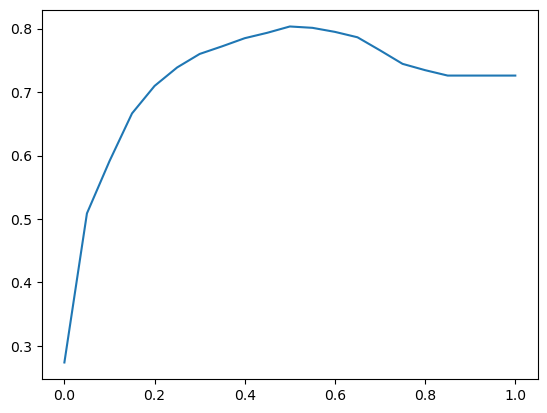

In [19]:
# Plot of accuracy scores by thresholds
plt.plot(thresholds, scores);

The dummy model predicting `1` for all observations has $73\%$ accuracy, only $7\%$ less compared to our model. This is due to data imbalance.

In [21]:
# Count the number of soft predictions greater than or equal to 1
Counter(y_pred >= 1.0)

Counter({False: 1409})

We obtain `False` for all predictions, as they are all lower than 1.

In [23]:
# Distribution of `y`
Counter(y_val)

Counter({0: 1023, 1: 386})

It's not well balanced.

In [25]:
# Percentage of users not churning
1 - y_val.mean()

0.7260468417317246

For data imbalance problems, the `accuracy score` is then not suitable. It should be considered principally when the data is well balanced.

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [28]:
# Real values
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [29]:
# Decision threshold
t = 0.5

# Model's predictions
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [30]:
# Count of true positives
tp = (predict_positive & actual_positive).sum()
# Count of true negatives
tn = (predict_negative & actual_negative).sum()

# Count of false positives
fp = (predict_positive & actual_negative).sum()
# Count of false negatives
fn = (predict_negative & actual_positive).sum()

In [31]:
# Confusion matrix
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [32]:
# Normalized Confusion matrix (with relative numbers / percentages instead of absolute numbers)
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [34]:
# Accuracy
acc = (tp + tn) / (tp + tn + fp + fn)
acc

0.8034066713981547

In [35]:
# Precision
p = tp / (tp + fp)
p

0.6752411575562701

In [36]:
# Recall / sensitivity
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves

### TPR and FRP

In [38]:
# True positive rate / recall / sensitivity
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [39]:
# False positive rate
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [40]:
# Initialize scores
scores = []

# List of thresholds
thresholds = np.linspace(0, 1, 101)

# Tuning with possibe thresholds
for t in thresholds:
    # Real values
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    # Model's predictions
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    # Count of true positives (tp) and true negatives (tn)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    # Count of false positives (fp) and false negatives (fn)
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # Append threshold and scores
    scores.append((t, tp, fp, fn, tn))

In [41]:
# Column names
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
# Create a dataframe
df_scores = pd.DataFrame(scores, columns = columns)

# Compute TPR and FPR metrics
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

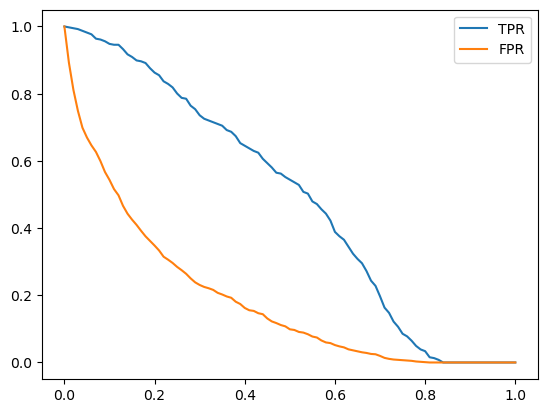

In [42]:
# Plot TPR and FPR
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend();

We want the `FPR` to be minimized as far as possible and the TPR to be maximized as far as possible.

### Random model

In [45]:
# Set the seed for reproducibility
np.random.seed(1)

# random predictions with the uniform distribution
y_rand = np.random.uniform(0, 1, size = len(y_val))

In [46]:
# random model accuracy
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [47]:
# Function for returning a model FPR and TPR scores
def tpr_fpr_dataframe(y_val, y_pred):
    # Initialize scores
    scores = []

    # List of thresholds
    thresholds = np.linspace(0, 1, 101)

    # Tuning with possible thresholds
    for t in thresholds:
        # Real values
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        # Model's predictions
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # Count of true positives (tp) and true negatives (tn)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        # Count of false positives (fp) and false negatives (fn)
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        # Store threshold and scores
        scores.append((t, tp, fp, fn, tn))

    # Columns names
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    # Create dataframe for storing results
    df_scores = pd.DataFrame(scores, columns = columns)

    # Compute TPR and FPR metrics
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    # return result
    return df_scores

In [48]:
# Compute scores for the random model
df_rand = tpr_fpr_dataframe(y_val, y_rand)

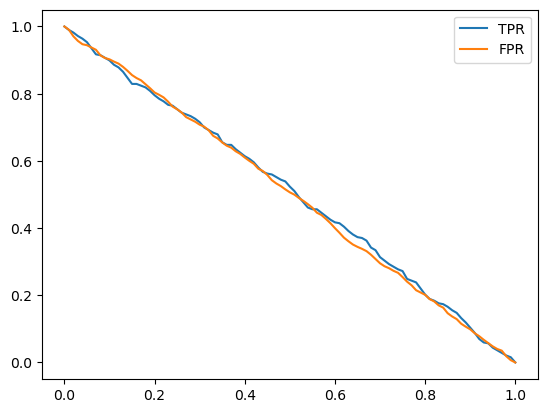

In [49]:
# Plot TPR and FPR for the random model
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend();

### Ideal model

In [51]:
# Count of negative values
num_neg = (y_val == 0).sum()
# Count of positive values
num_pos = (y_val == 1).sum()
# Ouput Counts
num_neg, num_pos

(1023, 386)

In [52]:
# Actual values
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

# Create predictions
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [53]:
# Percentage of users churning
y_val.mean()

0.2739531582682754

In [54]:
# Percentage of users not churning
1 - y_val.mean()

0.7260468417317246

In [55]:
# model's score
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [56]:
# Dataframe result
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
# See some values (skipping 10 observations each time)
df_ideal[ : : 10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


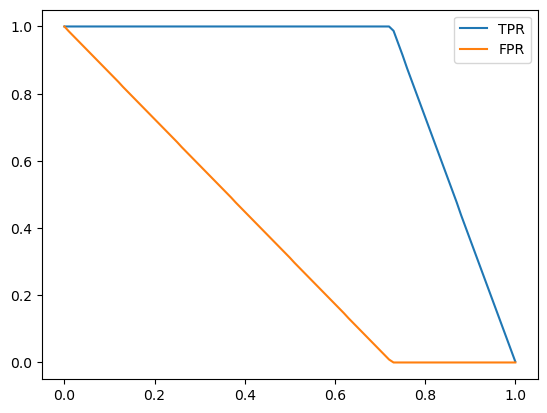

In [57]:
# Plot ideal model TPR and FPR
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR')
plt.legend();

### Putting everything together

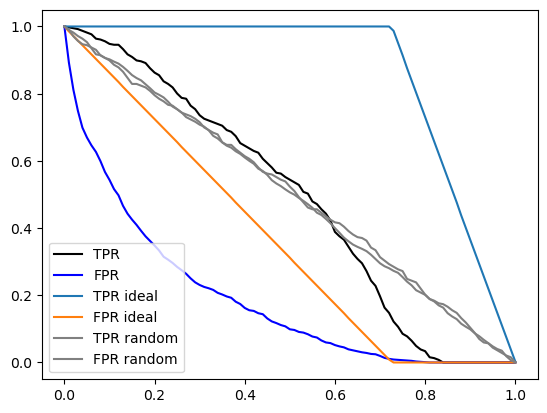

In [59]:
# TPR and FPR curves
# Our model
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR', color = 'black')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR', color = 'blue')

# Ideal model
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR ideal')

# Random model
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR random', color = 'grey')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR random', color = 'grey')

# Legend
plt.legend();

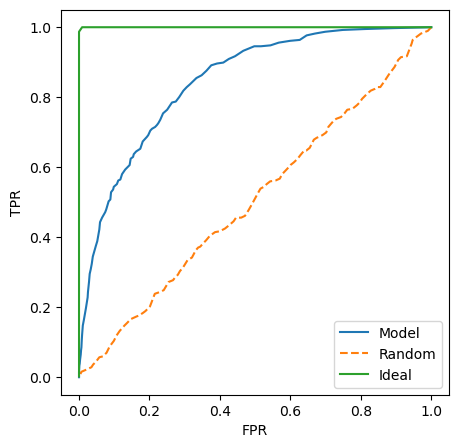

In [60]:
# Figure size
plt.figure(figsize = (5, 5))

# Plot ROC Curves
plt.plot(df_scores.fpr, df_scores.tpr, label = 'Model')
plt.plot(df_rand.fpr, df_rand.tpr, label = 'Random', linestyle = '--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'Ideal')

# Labels and legend
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

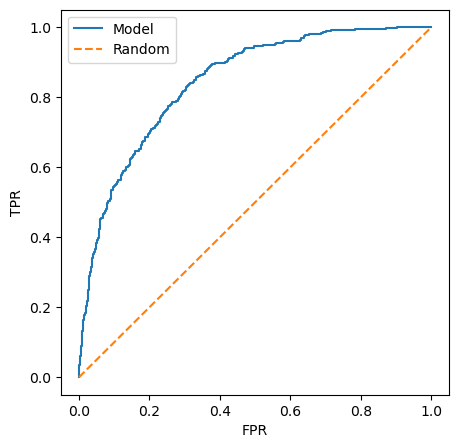

In [61]:
# Using the function built-in we can get fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Figure size
plt.figure(figsize=(5, 5))

# Plot ROC Curves
plt.plot(fpr, tpr, label = 'Model')
plt.plot([0, 1], [0, 1], label = 'Random', linestyle = '--')

# Labels and legend
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [63]:
# Ectract scores with sklearn
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Area under the curve with sklearn scores
auc(fpr, tpr)  

0.8438429084426076

In [64]:
# Area under the curve with scores calculated manually
auc(df_scores.fpr, df_scores.tpr)

0.8438264476623158

In [65]:
# Area under the curve for the ideal model
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

Note that instead of extracting the `fpr`, `tpr`, and `thresholds` to compute the area under the curve, we can directly use a function in `sklearn.metrics` for that: 

In [67]:
# Area under the ROC curve
roc_auc_score(y_val, y_pred)

0.8438429084426076

In [68]:
# Scores for negative samples
neg = y_pred[y_val == 0]

# Scores for positive samples
pos = y_pred[y_val == 1]

In [69]:
# Number of random selection
n = 100000
# Initialize score
success = 0 

for i in range(n):
    # Random index for positive sample
    pos_ind = random.randint(0, len(pos) - 1)
    # Random index for negative sample
    neg_ind = random.randint(0, len(neg) - 1)

    # Check the probability of randomly selected positive
    # samples is higher than the one for negative samples
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

# AUC
success / n

0.84334

In [70]:
# Number of indexes (for random selections)
n = 50000

# Set the seed for reproducibility
np.random.seed(1)
# Random indexes for positive samples
pos_ind = np.random.randint(0, len(pos), size = n)
# Random indexes for negative samples
neg_ind = np.random.randint(0, len(neg), size = n)

# Get the AUC score
(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [72]:
# Function for training a logistic regression model
def train(df_train, y_train, C = 1.0):
    # Convert data to list of dictionaries
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')

    # Initialize One-Hot-Encoder
    dv = DictVectorizer(sparse = False)
    # One-Hot-Encoding
    X_train = dv.fit_transform(dicts)

    # Initialize Logistic Regression model
    model = LogisticRegression(C = C, max_iter = 10000)
    # Model training
    model.fit(X_train, y_train)

    # return logistic regression model and One-Hot-Encoder
    return dv, model

In [73]:
# Call of our `train` function
dv, model = train(df_train, y_train, C = 0.001)

In [74]:
# Function to make predictions
def predict(df, dv, model):
    # Convert data to list of dictionaries
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    # One-Hot-Encoding
    X = dv.transform(dicts)
    # Make soft predictions
    y_pred = model.predict_proba(X)[:, 1]

    # return predictions
    return y_pred

In [75]:
# Call of our `predict` function
y_pred = predict(df_val, dv, model)
y_pred

array([0.02500499, 0.23984214, 0.24624322, ..., 0.24668902, 0.75574332,
       0.75905493])

In [76]:
# Number of splits
n_splits = 5

# List of parameters
tun_params = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]

# Parameter (C -> regularization) fine-tuning
for C in tqdm(tun_params):
    # Kfold cross-validation
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

    # Initialize scores
    scores = []

    # For each iteration of K-fold split and the pair of indexes generated
    for train_idx, val_idx in kfold.split(df_full_train):
        # Select train and validation data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # Select target variables
        y_train = df_train.churn.values
        y_val = df_val.churn.values

        # Train model
        dv, model = train(df_train, y_train, C = C)
        # Make predictions
        y_pred = predict(df_val, dv, model)

        # Get score
        auc = roc_auc_score(y_val, y_pred)
        # Store score
        scores.append(auc)

    # Print results
    print('C = %s, mean = %.3f, std = +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C = 0.001, mean = 0.825, std = +- 0.009
C = 0.01, mean = 0.840, std = +- 0.008
C = 0.1, mean = 0.842, std = +- 0.007
C = 0.5, mean = 0.842, std = +- 0.007
C = 1, mean = 0.842, std = +- 0.007
C = 5, mean = 0.842, std = +- 0.007
C = 10, mean = 0.842, std = +- 0.007


In [77]:
# Visualize scores for `C = 10`
pd.Series(scores, name = "scores")

0    0.843957
1    0.844795
2    0.833679
3    0.834797
4    0.852083
Name: scores, dtype: float64

In [78]:
# Model training with optimized parameter
dv, model = train(df_full_train, df_full_train.churn.values, C = 1.0)
# Make predictions
y_pred = predict(df_test, dv, model)

# Get the AUC score
auc = roc_auc_score(y_test, y_pred)
auc

0.8585034179423012

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week

---